Many parts of the code used in this notebook are copied from the following repos and modified as needed to adapt to the example being demonstrated here:
* https://github.com/PacktPublishing/Mastering-Reinforcement-Learning-with-Python/blob/master/Chapter03/Contextual%20Bandits.ipynb
* https://github.com/jldbc/bandits/tree/master/bandits

The MIT license notices of these repos can be found in the **References** section below.

# Setup

In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
# define a class with necessary functions for generating users for the simulation below
# data generation process works as follows:
#   user is assigned a set of random context values (location, device, age)
#   user's probability of clicking on an ad depends on their context as well as whether they see the C or T ad
#   the probability of clicking is modeled as a logistic function of context (different parameters for C and T)

class UserGenerator(object):
    def __init__(self):
        self.beta = {}
        self.beta['C'] = np.array([-6, -0.1, 1, 0.1])
        self.beta['T'] = np.array([-3.5, -0.1, -3, 0.1]) 
        self.context = None
        
    def logistic(self, beta, context):
        f = np.dot(beta, context)
        p = 1 / (1 + np.exp(-f))
        return p
    
    def display_ad(self, ad):
        if ad in ['C', 'T']:
            p = self.logistic(self.beta[ad], self.context)
            reward = np.random.binomial(n=1, p=p)
            return reward
        else:
            raise Exception('Unknown ad!')      
    
    def generate_user_with_context(self):
        location = np.random.binomial(n=1, p=0.6)
        device = np.random.binomial(n=1, p=0.8)
        age = 10 + int(np.random.beta(2, 3) * 60)
        self.context = [1, device, location, age]
        return self.context

In [3]:
# define random policy for A/B test
# an ad (C or T) is selected randomly with probabilities p

def ab_policy(arms, slate_size=1, p=[0.6, 0.4]):
    recs = np.random.choice(arms, size=(slate_size), replace=False, p=p)
    return recs

In [4]:
# define e-greedy policy for MAB
# policy first decides whether to explore or exploit
# if explore is selected, then an ad (C or T) is chosen randomly
# if exploit is selected, then the ad that currently has the highest average y is chosen

def mab_policy_egreedy(df, arms, epsilon=0.15, slate_size=1):
    explore = np.random.binomial(1, epsilon)
    if explore == 1 or df.shape[0]==0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)
    else:
        scores = df[['d', 'y']].groupby('d').agg({'y': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['d'] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], 'd'].values
    return recs

In [5]:
# define a function to be used when deciding whether to keep a sample or not when doing A/B and MAB replay
# function compares the selected ad (C or T) to the logged ads in the batch and only keeps matching ads

def score(history, df, t, batch_size, recs):
    actions = df[t:t+batch_size]
    actions = actions.loc[actions['d'].isin(recs)]
    actions['scoring_round'] = t
    history = pd.concat([history, pd.DataFrame(actions)])
    action_liked = actions[['d', 'y']]
    return history, action_liked

In [6]:
# define a regularized logistic regression class to be used with CB to learn the relationship between y and X
# separate LR models will be learned for C and T

class RegularizedLR(object):
    def __init__(self, name, alpha, rlambda, n_dim):
        self.name = name
        self.alpha = alpha
        self.rlambda = rlambda
        self.n_dim = n_dim
        self.m = np.zeros(n_dim)
        self.q = np.ones(n_dim) * rlambda
        self.w = self.get_sampled_weights()
        
    def get_sampled_weights(self):    
        w = np.random.normal(self.m, self.alpha * self.q**(-1/2))
        return w
        
    def loss(self, w, *args):
        X, y = args
        n = len(y)
        regularizer = 0.5 * np.dot(self.q, (w - self.m)**2)
        pred_loss = sum([np.log(1 + np.exp(np.dot(w, X[j])))
                                    - y[j] * np.dot(w, X[j]) for j in range(n)])
        return regularizer + pred_loss
    
    def fit(self, X, y):
        if y:
            X = np.array(X)
            y = np.array(y)
            minimization = minimize(self.loss, 
                                    self.w, 
                                    args=(X, y), 
                                    method="L-BFGS-B", 
                                    bounds=[(-10,10)]*3 + [(-1, 1)],
                                    options={'maxiter': 50})
            self.w = minimization.x
            self.m = self.w
            p = (1 + np.exp(-np.matmul(self.w, X.T)))**(-1)
            self.q = self.q + np.matmul(p * (1 - p), X**2)
    
    
    def calc_sigmoid(self, w, context):
        return 1 / (1 + np.exp(-np.dot(w, context)))
    
    def get_prediction(self, context):
        return self.calc_sigmoid(self.m, context)
    
    def sample_prediction(self, context):
        w = self.get_sampled_weights()
        return self.calc_sigmoid(w, context)
    
    def get_ucb(self, context):
        pred = self.calc_sigmoid(self.m, context)
        confidence = self.alpha * np.sqrt(np.sum(np.divide(np.array(context)**2, self.q)))
        ucb = pred + confidence
        return ucb

In [7]:
# define e-greedy policy for CB
# policy first decides whether to explore or exploit
# if explore is selected, then an ad (C or T) is chosen randomly
# if exploit is selected, then the ad that gives the highest CTR based on the model is returned

def cb_policy_egreedy(ad_models, context, eps):
    if np.random.uniform() < eps:
        return np.random.choice(list(ad_models.keys()))
    else:
        predictions = {ad: ad_models[ad].get_prediction(context) 
                       for ad in ad_models}
        max_value = max(predictions.values()); 
        max_keys = [key for key, value in predictions.items() if value == max_value]
        return np.random.choice(max_keys)

# Simulate logged data

In [8]:
# we'll simulate 100,000 users that receive T with probability 0.75

num_samples = 100000
prob_treated = 0.75

In [9]:
# initialize the dataframe

df = pd.DataFrame(np.nan, index=range(0, num_samples), columns=['d', 'y', 'b0', 'b1', 'b2', 'b3',])

print(df.shape)
df.head()

(100000, 6)


,d,y,b0,b1,b2,b3
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# generate the users

ug = UserGenerator()

for i in range(0, num_samples):
    context = ug.generate_user_with_context()
    d = np.random.binomial(1, prob_treated)
    if d == 0:
        y = ug.display_ad('C')
    else:
        y = ug.display_ad('T')
    df.loc[i] = [d, y] + context

df['t'] = range(0, df.shape[0])

print(df.shape)
df.head()

(100000, 7)


,d,y,b0,b1,b2,b3,t
0,1.0,0.0,1.0,1.0,1.0,28.0,0
1,1.0,0.0,1.0,1.0,1.0,33.0,1
2,0.0,1.0,1.0,1.0,1.0,30.0,2
3,1.0,0.0,1.0,1.0,0.0,32.0,3
4,1.0,0.0,1.0,1.0,1.0,38.0,4


In [11]:
# calculate the fraction of users that received T (should be ~0.75)
# and the average y values by C and T (T should be higher by ~0.06)

print(df.d.mean())
print()
print(df.groupby('d').mean()[['y']])

0.74874

            y
d            
0.0  0.160471
1.0  0.223175


In [12]:
# upsample C and downsample T to get a new dataset that is 50/50% C/T
# this step is needed because the original data doesn't assign C/T uniformly at random

df0 = df[df.d == 0].sample(50000, replace=True)
df1 = df[df.d == 1].sample(50000, replace=True)

df = pd.concat([df0, df1], ignore_index=True)

df.drop(columns=['t'])

df = df.sample(frac=1).reset_index(drop=True)

df['t'] = range(0, df.shape[0])

print(df.shape)
df.head()

(100000, 7)


,d,y,b0,b1,b2,b3,t
0,1.0,0.0,1.0,1.0,0.0,50.0,0
1,0.0,0.0,1.0,1.0,1.0,36.0,1
2,0.0,0.0,1.0,1.0,0.0,34.0,2
3,1.0,0.0,1.0,1.0,1.0,28.0,3
4,1.0,0.0,1.0,1.0,1.0,19.0,4


In [13]:
# double check that fraction T is now 0.5
# but the average y values are still very close to before

print(df.d.mean())
print()
print(df.groupby('d').mean()[['y']])

0.5

           y
d           
0.0  0.15968
1.0  0.22232


# Calculate cumulative reward for A/B

In [14]:
history = pd.DataFrame(data=None, columns=df.columns)

rewards = []
max_time = df.shape[0]

batch_size = 100
n = 1

for t in range(max_time//batch_size):
	t = t * batch_size
	recs = ab_policy(arms=df.d.unique(), slate_size=n, p=[0.6, 0.4])
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.y.tolist()
		rewards.extend(action_score)

rewards_ab = rewards
history_ab = history

print(len(rewards_ab))
rewards_ab[:10]

50030


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
cumulative_ab = np.cumsum(rewards_ab)

print(len(cumulative_ab))
cumulative_ab[:10]

50030


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Calculate cumulative reward for MAB

In [16]:
history = pd.DataFrame(data=None, columns=df.columns)

rewards = []
max_time = df.shape[0]

batch_size = 100
epsilon = 0.15
n = 1

for t in range(max_time//batch_size):
	t = t * batch_size
	recs = mab_policy_egreedy(df=history.loc[history.t<=t,], arms=df.d.unique(), epsilon=epsilon, slate_size=n)
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.y.tolist()
		rewards.extend(action_score)

rewards_mab = rewards
history_mab = history

print(len(rewards_mab))
rewards_mab[:10]

49830


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [17]:
cumulative_mab = np.cumsum(rewards_mab)

print(len(cumulative_mab))
cumulative_mab[:10]

49830


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Calculate cumulative reward for CB

In [18]:
history = pd.DataFrame(data=None, columns=df.columns)

rewards = []
max_time = df.shape[0]

batch_size = 10000
eps = 0.15

ad_options = ['C', 'T']

alpha, rlambda, n_dim = 0.5, 0.5, 4
ad_models = {ad: RegularizedLR(ad, alpha, rlambda, n_dim) for ad in 'CT'}

X = {ad: [] for ad in ad_options}
y = {ad: [] for ad in ad_options}

for t in range(max_time):
    
    context = list(df.iloc[t][['b0', 'b1', 'b2', 'b3']])
    
    ad = cb_policy_egreedy(ad_models, context, eps)
    
    if (ad == 'C' and df.iloc[t]['d'] == 0) or (ad == 'T' and df.iloc[t]['d'] == 1):
        
        click = df.iloc[t]['y']
        
        actions = df[t:t+1]
        actions['scoring_round'] = t
        history = pd.concat([history, pd.DataFrame(actions)])
        action_score = actions[['d', 'y']]
        action_score = action_score.y.tolist()
        rewards.extend(action_score)

        X[ad].append(context)
        y[ad].append(click)
        
    if (t + 1) % batch_size == 0:
        print("Updating the models at t:", t + 1)
        for ad in ad_options:
            ad_models[ad].fit(X[ad], y[ad])
        X = {ad: [] for ad in ad_options}
        y = {ad: [] for ad in ad_options}

rewards_cb = rewards
history_cb = history

print()
print(len(rewards_cb))
rewards_cb[:10]

Updating the models at t: 10000
Updating the models at t: 20000
Updating the models at t: 30000
Updating the models at t: 40000
Updating the models at t: 50000
Updating the models at t: 60000
Updating the models at t: 70000
Updating the models at t: 80000
Updating the models at t: 90000
Updating the models at t: 100000

50333


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [19]:
cumulative_cb = np.cumsum(rewards_cb)

print(len(cumulative_cb))
cumulative_cb[:10]

50333


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

# Cumulative reward comparison: A/B vs MAB vs CB

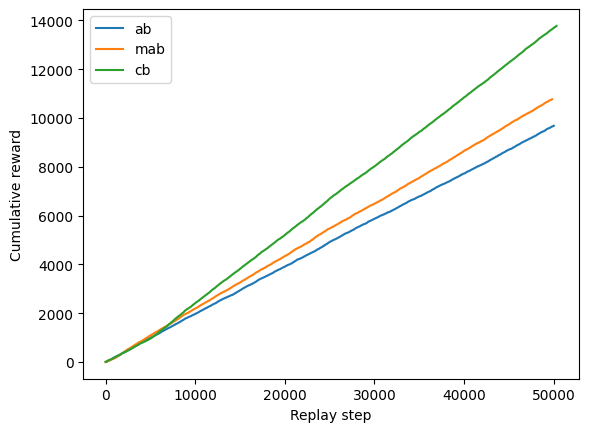

In [20]:
plt.plot(cumulative_ab, label='ab')
plt.plot(cumulative_mab, label='mab')
plt.plot(cumulative_cb, label='cb')

plt.xlabel("Replay step")
plt.ylabel("Cumulative reward")

plt.legend()

plt.savefig('ab_vs_mab_vs_cb.png')

In [21]:
print(cumulative_cb[-1] - cumulative_mab[-1])
print(cumulative_cb[-1] - cumulative_ab[-1])
print(cumulative_mab[-1] - cumulative_ab[-1])

3006.0
4096.0
1090.0


# Reference

Many parts of the code in this notebook are copied from the following scripts and modified as needed to adapt to the example being demonstrated here:
* https://github.com/PacktPublishing/Mastering-Reinforcement-Learning-with-Python/blob/master/Chapter03/Contextual%20Bandits.ipynb
* https://github.com/jldbc/bandits/tree/master/bandits

The repositories where these code snippets originally appeared in have the following LICENSE notices.

MIT License

Copyright (c) 2020 Packt

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

MIT License

Copyright (c) 2019 James LeDoux

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.